## Part 1: First, make a baseline model to determine between 3's and 7's

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/storage/data/mnist_sample')

In [3]:
# Path.BASE_PATH = path

In [4]:
# look inside of the train folder from the path to see what is located inside
(path/'train').ls()

(#2) [Path('/storage/data/mnist_sample/train/3'),Path('/storage/data/mnist_sample/train/7')]

In [5]:
# get the 3s and 7s
threes = (path/'train'/'3').ls()
threes

(#6131) [Path('/storage/data/mnist_sample/train/3/55705.png'),Path('/storage/data/mnist_sample/train/3/32379.png'),Path('/storage/data/mnist_sample/train/3/36132.png'),Path('/storage/data/mnist_sample/train/3/50201.png'),Path('/storage/data/mnist_sample/train/3/39704.png'),Path('/storage/data/mnist_sample/train/3/8475.png'),Path('/storage/data/mnist_sample/train/3/5139.png'),Path('/storage/data/mnist_sample/train/3/32610.png'),Path('/storage/data/mnist_sample/train/3/7784.png'),Path('/storage/data/mnist_sample/train/3/45704.png')...]

In [6]:
sevens = (path/'train'/'7').ls()
sevens

(#6265) [Path('/storage/data/mnist_sample/train/7/23645.png'),Path('/storage/data/mnist_sample/train/7/13644.png'),Path('/storage/data/mnist_sample/train/7/22228.png'),Path('/storage/data/mnist_sample/train/7/2229.png'),Path('/storage/data/mnist_sample/train/7/6064.png'),Path('/storage/data/mnist_sample/train/7/24505.png'),Path('/storage/data/mnist_sample/train/7/26356.png'),Path('/storage/data/mnist_sample/train/7/19987.png'),Path('/storage/data/mnist_sample/train/7/19592.png'),Path('/storage/data/mnist_sample/train/7/49413.png')...]

In [7]:
# exmaine one of the images
example_seven = Image.open(sevens[0])
example_seven

## Build the baseline model that makes the average 3/7

In [8]:
# convert the urls into a list of tensors
threes_tensor_list = [tensor(Image.open(three_path)) for three_path in threes]


In [9]:
sevens_tensor_list = [tensor(Image.open(seven_path)) for seven_path in sevens]

In [10]:
# stack the tensors to create a single 3D tensor
threes_tensor = torch.stack(threes_tensor_list)/255
threes_tensor_2 = torch.stack(threes_tensor_list).float()/255

print((threes_tensor == threes_tensor_2).all())

tensor(True)


In [11]:
# create single 3 and 7 tensors by stacking the list and convert the values into 0-1 range
threes_tensor = torch.stack(threes_tensor_list)/255
sevens_tensor = torch.stack(sevens_tensor_list)/255

In [12]:
# experiment with shape and dimensions in pytorch
threes_tensor.shape, threes_tensor.ndim

(torch.Size([6131, 28, 28]), 3)

<AxesSubplot:>

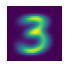

In [13]:
# to calculte the 'averaged' 3, we must take a running average through the 1st dimension (over all of the 3s)
av_3 = threes_tensor.mean(0)
show_image(av_3)

<AxesSubplot:>

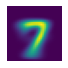

In [14]:
# do the same for the 'averaged' 7
av_7 = sevens_tensor.mean(0)
show_image(av_7)

### To predict between 3s and 7s, we must be able to compare between the current number and the ideal numbers
- Attempt to implement MAE  and RMSE manually and also using the pytorch built in error metrics

In [15]:
# manually create a mae function
def manual_mae(num_tensor, ideal_num):
    # note that due to broadcasting, num_tensor can be a 2D tensor or a 3D tensor (a tensor containing multiple image tensors) and pytorch will be able to cotinue with the computations
    # take the mean over the final 2 dimensions - the image dimensions
    return torch.mean(abs(num_tensor-ideal_num), (-2, -1))

In [16]:
# use one a single image, then use broadcasting to use on all images
manual_mae(threes_tensor[0], av_3), manual_mae(threes_tensor, av_3)

(tensor(0.1397),
 tensor([0.1397, 0.1281, 0.1542,  ..., 0.1159, 0.1253, 0.1337]))

In [17]:
# manually create rmse function
def manual_rmse(num_tensor, ideal_num):
    return torch.sqrt(torch.mean((num_tensor - ideal_num)**2, (-2, -1)))

In [18]:
manual_rmse(threes_tensor[0], av_3), manual_rmse(threes_tensor, av_3).mean()

(tensor(0.2532), tensor(0.2373))

In [19]:
pytorch_rmse = lambda num_tensor, ideal: F.mse_loss(num_tensor, ideal).sqrt()

In [20]:
pytorch_rmse(threes_tensor[0], av_3), pytorch_rmse(threes_tensor, av_3)

<ipython-input-19-fa4fa006808b>:1: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([6131, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pytorch_rmse = lambda num_tensor, ideal: F.mse_loss(num_tensor, ideal).sqrt()


(tensor(0.2532), tensor(0.2394))

In [21]:
def is_3(input_tensor):
    return manual_rmse(input_tensor, av_3) < manual_rmse(input_tensor, av_7) 

In [22]:
# calculate the accuracy of all 3s and all 7s

acc_3 = is_3(torch.stack([tensor(Image.open(valid_3_path)) for valid_3_path in (path/'valid'/'3').ls()])/255).float().mean()
acc_3



tensor(0.9584)

In [23]:
acc_7 = (1 - is_3(torch.stack([tensor(Image.open(valid_7_path)) for valid_7_path in (path/'valid'/'7').ls()]))/255).float().mean()
acc_7

tensor(0.9997)

## Part 2: Use Gradient Descent using Pytorch on a few mathematical functions
- Write step by step what each example is doing in sgd
- Start working with a linear function
- Visualize the results

In [26]:
x_points = torch.arange(0, 20).float()
x_points

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])